In [2]:
import cv2
import urllib
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode

# Input your image
I'm using an online example. You should import the different test cases provided.

In [3]:
testing__image = "test_16"

In [4]:
img = cv2.imread(f'salama_tests_ordered/{testing__image}.jpg', cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

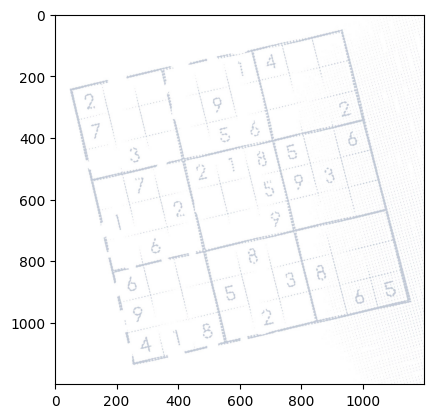

In [5]:
plt.imshow(img_rgb)

# Convert to grayscale
We don't need any color information.

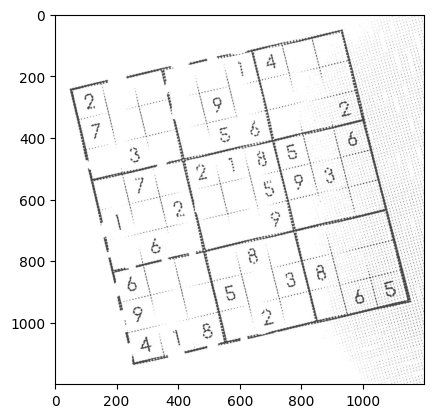

In [6]:
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
plt.imshow(img_gray, cmap="gray")

## Histogram

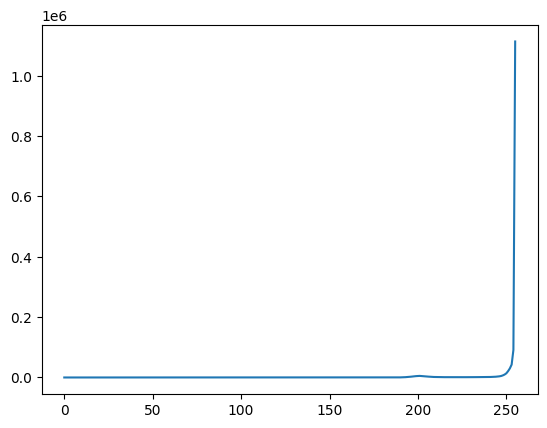

In [7]:
hist = cv2.calcHist([img_gray], [0], None, [256], [0, 256])

plt.plot(hist)

## Median Filter

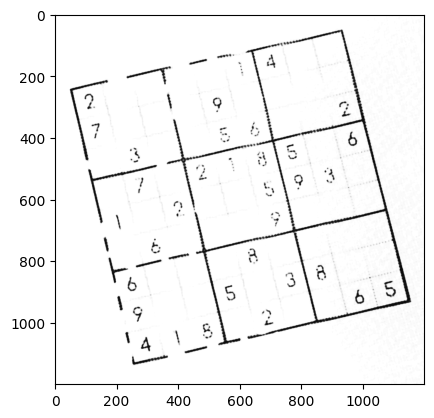

In [8]:
median_filtered_image = cv2.medianBlur(img_gray, 7)
plt.imshow(median_filtered_image, cmap="gray")

## Histogram Equalization

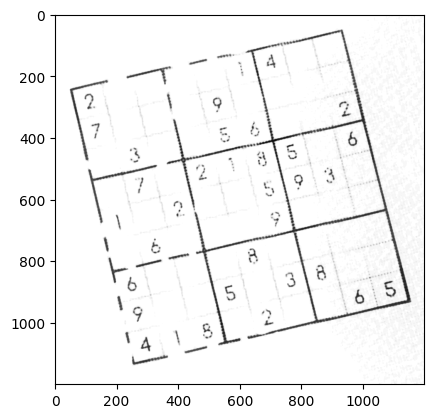

In [9]:
# equalized_image = cv2.equalizeHist(median_filtered_image)
# plt.imshow(equalized_image, cmap="gray")
equalized_image = cv2.createCLAHE(clipLimit=2, tileGridSize=(10, 10))
equalized_image = equalized_image.apply(median_filtered_image)
plt.imshow(equalized_image, cmap="gray")

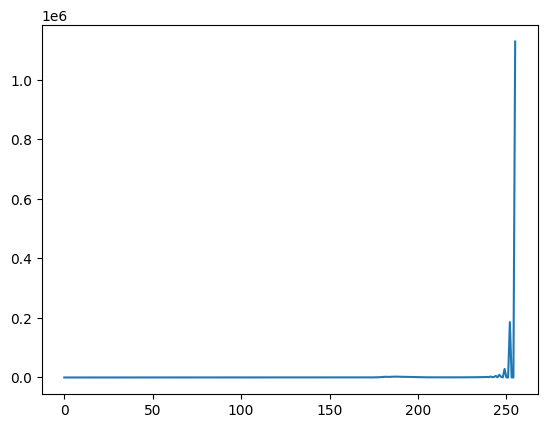

In [10]:
hist = cv2.calcHist([equalized_image], [0], None, [256], [0, 256])
plt.plot(hist)

## Contrast Stretching

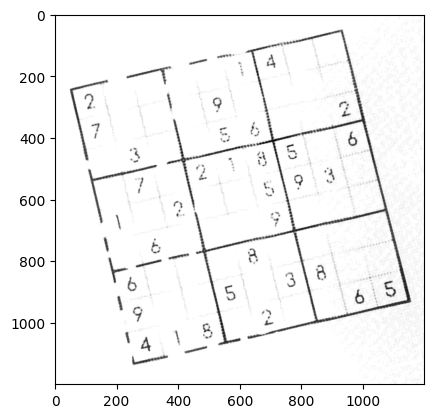

In [11]:
roi = equalized_image[0:-1, 0:-1]

roi_contrast_stretched = cv2.normalize(roi, None, 0, 255, cv2.NORM_MINMAX)

equalized_image[0:-1, 0:-1] = roi_contrast_stretched

plt.imshow(equalized_image, cmap="gray")

peaks:  600


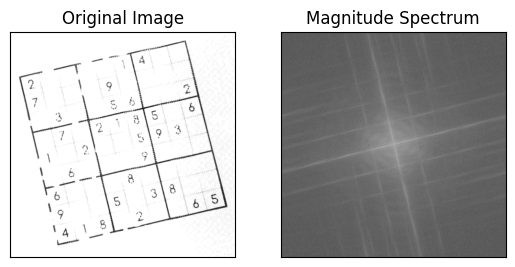

In [12]:
f_transform = np.fft.fft2(equalized_image)
f_shift = np.fft.fftshift(f_transform)

magnitude_spectrum = np.log(np.abs(f_shift) + 1)

peaks = cv2.minMaxLoc(magnitude_spectrum)[3]


threshold = 0.8
sine_wave_detected = peaks[0] > threshold
print("peaks: ", peaks[0])

plt.subplot(121), plt.imshow(equalized_image, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])

plt.show()

## Check If Image is Inverted

In [13]:
inverted_score = hist[0] + hist[-1]
print(inverted_score)
if (inverted_score==389):
   equalized_image = cv2.bitwise_not(equalized_image)

[1128437.]


## Sharpening

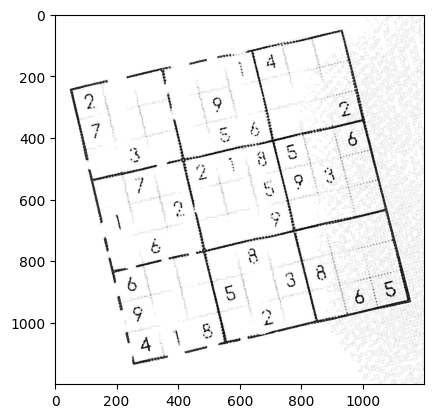

In [14]:
kernel = np.array([[-1, -1, -1],
                   [-1, 9, -1],
                   [-1, -1, -1]])
sharpened_image = cv2.filter2D(equalized_image, -1, kernel)

plt.imshow(sharpened_image, cmap="gray")

## Gaussian Blur

(1200, 1200, 3)


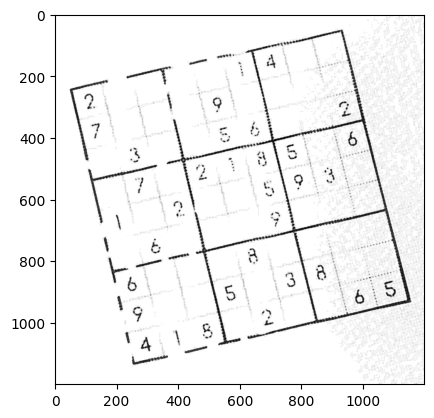

In [15]:
img_Blur = cv2.GaussianBlur(sharpened_image,(3,3),0)
plt.imshow(img_Blur, cmap="gray")
print(img.shape)

## Thresholding function to get C value based on histogram mode

In [16]:
mode_intensity = np.argmax(np.histogram(img_Blur.flatten(), bins=256)[0])
mean_intensity = np.mean(img_Blur)
percentile_value = np.percentile(img_Blur, 95)

In [17]:


def get_C_Value():
    flag = 0
    flag_image= False
    flag_image_noisy= False
    flag_image_hard= False
    flag_image_dark= False
    print("mode_intensity",mode_intensity)
    print("mean_intensity",mean_intensity)
    print("percentile_value",percentile_value)
    if(mode_intensity == 255 and mean_intensity == 240.070096 and percentile_value == 255.0):
        flag = 1
        print("10")
        print("Image is very Bright and faded")
        c_value = 10
    elif(mode_intensity == 184 and mean_intensity == 164.780776 and percentile_value == 222.0):
        flag = 2
        flag_image_noisy= True
        print("11")
        c_value = 80
    elif mode_intensity >=250 and mean_intensity ==240.070096:
        print("The image is very bright and edge case")
        c_value = 1
    elif mode_intensity ==184 and percentile_value ==222:
        print("very noisy")
        c_value = 80
    elif mode_intensity >=250 and mean_intensity == 242.67825416666668:
        print("The image is very bright and noisy")
        flag_image_hard = True
        c_value = 30
    elif mode_intensity >=250 :
        print("The image is very bright")
        c_value = 60
    elif mode_intensity==219:
      print("Edge case.")
      c_value= 10
    elif mode_intensity ==224:
        print("The image is half bright.")
        flag_image = True
        c_value = 10
    elif mode_intensity >=218:
        print("The image is bright.")
        c_value = 30
    elif mode_intensity==188 and percentile_value ==222:
      print("Edge case.")
      flag_image_dark = True
      c_value= 55
    elif mode_intensity==188:
      print("Edge case.")
      c_value= 20
    elif mode_intensity==172 and percentile_value ==209:
      print("Edge case.")
      c_value= 50
    elif mode_intensity==214:
      print("Edge case.")
      c_value= 60
    else:
      print("The image is not bright.")
      c_value = 8
    return c_value, flag_image, flag_image_noisy,flag_image_hard,flag_image_dark


In [18]:
C, flag_image,flag_image_noisy,flag_image_hard,flag_image_dark = get_C_Value()
C

mode_intensity 255
mean_intensity 242.67825416666668
percentile_value 255.0
The image is very bright and noisy


30

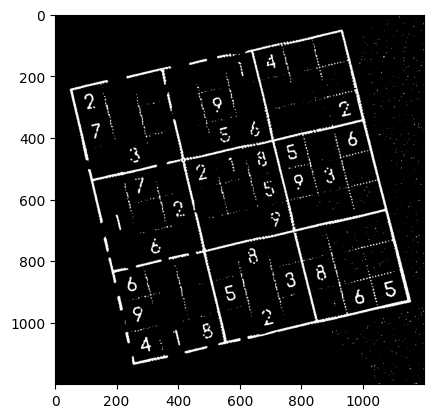

In [19]:
img_gray_threshed = cv2.adaptiveThreshold(src=img_Blur.astype(np.uint8),
    maxValue=255,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize= 97,
    C= C
)
plt.imshow(img_gray_threshed, cmap="gray")

In [20]:
if (mode_intensity ==227 and mean_intensity == 195.40163 and percentile_value == 243.0):
    img_gray_threshed = cv2.copyMakeBorder(img_gray_threshed, 7, 0, 0, 0, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    mask = np.zeros_like(img_gray_threshed)
    mask[:,180 :920 ] = 1
    img_gray_threshed_padded = np.multiply(img_gray_threshed, mask)
    img_gray_threshed = cv2.bitwise_or(img_gray_threshed, img_gray_threshed_padded)

    img_gray_threshed[0:10, 0:140] =0 # right
    img_gray_threshed[0:10, 920:] =0 #left
    img_gray_threshed[0:10, 140:280] =0 #refinement
    img_gray_threshed = cv2.copyMakeBorder(img_gray_threshed, 30, 0, 0, 15, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    img_gray_threshed[0:33, 270:400] =0 #refinement
    plt.imshow(img_gray_threshed, cmap="gray")

In [21]:
if (mode_intensity ==184 and mean_intensity == 164.780776 and percentile_value == 222.0):
    img_gray_threshed = cv2.copyMakeBorder(img_gray_threshed, 30, 0, 0, 15, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    plt.imshow(img_gray_threshed, cmap="gray")

In [22]:
if (mode_intensity ==192 and mean_intensity == 179.022805 and percentile_value == 208.0):
  #coin_mask = img_gray_threshed [0:90, 685: ]
  img_gray_threshed [0:90, 685: ]= 0
  img_gray_threshed [0:135, 915: ]= 0
  plt.imshow(img_gray_threshed, cmap="gray")

In [23]:
if (mode_intensity ==224 and mean_intensity == 211.177298 and percentile_value == 237.0):
    flipped_region = cv2.flip(img_gray_threshed[30:990, 930:], 1)

    img_gray_threshed[40:,10:80 ] = cv2.bitwise_or(flipped_region, img_gray_threshed[40:,10:80])
    img_gray_threshed[:, 0:30]= 0
    img_gray_threshed[:, 990:]= 0
    img_gray_threshed[990: , 0:300]= 0
    img_gray_threshed = cv2.copyMakeBorder(img_gray_threshed, 0, 20, 0, 0, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    plt.imshow(img_gray_threshed, cmap="gray")

In [24]:
if(mode_intensity == 255 and mean_intensity == 240.070096 and percentile_value == 255.0):

  img_gray_threshed = cv2.copyMakeBorder(img_gray_threshed, 40, 40, 40, 40, cv2.BORDER_CONSTANT, value=[0, 0, 0])

## Closing:

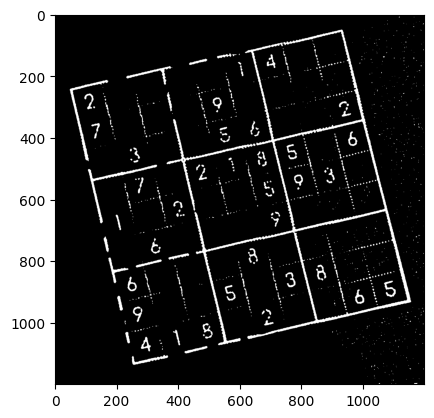

In [25]:
kernel = np.ones((3, 3), np.uint8)

dilated_image = cv2.morphologyEx(img_gray_threshed, cv2.MORPH_CLOSE, kernel)
plt.imshow(dilated_image, cmap="gray")

img_gray_threshed = dilated_image


In [26]:
if flag_image:
  edges = cv2.Canny(img_gray_threshed, 50, 150, apertureSize=3)

  lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=20, minLineLength=5, maxLineGap=3)
  img_with_lines = dilated_image.copy()

  if lines is not None:
      for line in lines:
          x1, y1, x2, y2 = line[0]
          cv2.line(dilated_image, (x1, y1), (x2, y2), 255, 2)

  kernel = np.ones((1, 60) , np.uint8)
  dilated_image[0:60,40:200] = cv2.morphologyEx(dilated_image[0:60,40:200], cv2.MORPH_CLOSE, kernel)
  dilated_image[980:1000,40:200] = cv2.morphologyEx(dilated_image[980:1000,40:200], cv2.MORPH_CLOSE, kernel)


  kernel = np.ones((3, 3), np.uint8)
  dilated_image = cv2.erode(dilated_image, kernel, iterations=1)
  plt.imshow(dilated_image, cmap="gray")

1998.851670334745
1999.4639281567447
1999.3008778070398
1998.3265498911833
1999.0760365728963
1999.3008778070398
1999.4639281567447
1999.0760365728963
1999.4639281567447
1999.3008778070398
1999.7479841219993


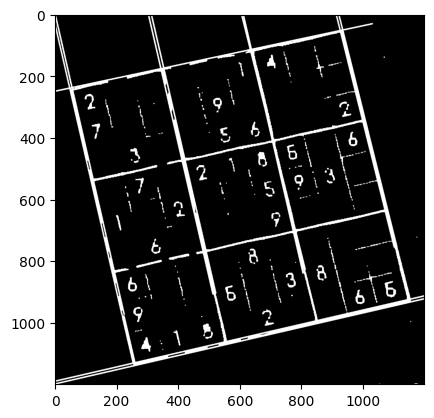

In [27]:
if flag_image_hard:
  kernel = np.ones((3, 3), np.uint8)
  dilated_image = cv2.morphologyEx(dilated_image, cv2.MORPH_ERODE, kernel)
  dilated_image = cv2.morphologyEx(dilated_image, cv2.MORPH_DILATE, np.ones((5, 5), np.uint8))
  point1 = (220,980)
  point2= (255,1130)
  cv2.line(dilated_image, point1, point2, (255, 255, 255), 11)
  dilated_image = cv2.morphologyEx(dilated_image, cv2.MORPH_DILATE, np.ones((10, 10), np.uint8))
  dilated_image = cv2.morphologyEx(dilated_image, cv2.MORPH_ERODE, np.ones((12, 12), np.uint8))
  edges = cv2.Canny(dilated_image, 50, 150)


  lines = cv2.HoughLines(edges, 1, np.pi / 180, threshold=210)

  for line in lines:
      rho, theta = line[0]
      a = np.cos(theta)
      b = np.sin(theta)
      x0 = a * rho
      y0 = b * rho
      x1 = int(x0 + 1000 * (-b))
      y1 = int(y0 + 1000 * (a))
      x2 = int(x0 - 1000 * (-b))
      y2 = int(y0 - 1000 * (a))

      line_length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
      print(line_length)

      cv2.line(dilated_image, (x1, y1), (x2, y2), (255, 255, 255), 3)
  plt.imshow(dilated_image,cmap="gray")

In [28]:
if flag_image_dark:
  dilated_image = cv2.morphologyEx(dilated_image, cv2.MORPH_ERODE, np.ones((3, 3), np.uint8))

  edges = cv2.Canny(dilated_image, 50, 150)


  lines = cv2.HoughLines(edges, 1, np.pi / 180, threshold=210)

  for line in lines:
      rho, theta = line[0]
      a = np.cos(theta)
      b = np.sin(theta)
      x0 = a * rho
      y0 = b * rho
      x1 = int(x0 + 1000 * (-b))
      y1 = int(y0 + 1000 * (a))
      x2 = int(x0 - 1000 * (-b))
      y2 = int(y0 - 1000 * (a))

      line_length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
      print(line_length)

      cv2.line(dilated_image, (x1, y1), (x2, y2), (255, 255, 255), 3)

  dilated_image = cv2.morphologyEx(dilated_image, cv2.MORPH_DILATE, np.ones((13, 13), np.uint8))
  dilated_image = cv2.morphologyEx(dilated_image, cv2.MORPH_ERODE, np.ones((9, 9), np.uint8))
  dilated_image = cv2.copyMakeBorder(dilated_image, 40, 40, 40, 40, cv2.BORDER_CONSTANT, value=[0, 0, 0])
  plt.imshow(dilated_image, cmap="gray")

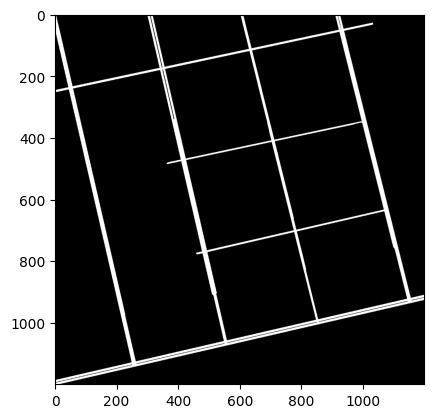

In [29]:
if flag_image_dark or flag_image_hard :
  # Detect lines that are not smaller in length than:
  minLineLength = min(dilated_image.shape[0],dilated_image.shape[1])/2

  lines = cv2.HoughLinesP(
      image=dilated_image,
      rho=1,
      theta=np.pi/180,
      threshold=200,
      minLineLength=minLineLength,
      maxLineGap=17
  )

  tmp_img = np.zeros_like(dilated_image, dtype = np.uint8)
  for x1, y1, x2, y2 in lines[:,0]: cv2.line(tmp_img,(x1,y1),(x2,y2),(255,0,0),2)
  plt.imshow(tmp_img, cmap='gray')

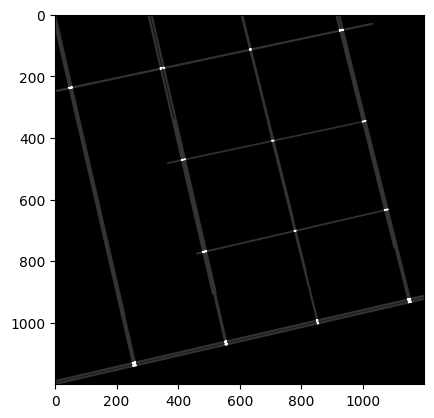

In [30]:
if flag_image_dark or flag_image_hard:
  tmp_img2 = np.zeros_like(dilated_image, dtype = np.uint16)

  def angle_between_lines(line1, line2):
      l1x1, l1y1, l1x2, l1y2 = line1
      l2x1, l2y1, l2x2, l2y2 = line2
      a1 = np.rad2deg(np.arctan2(l1y2 - l1y1, l1x2 - l1x1))
      a2 = np.rad2deg(np.arctan2(l2y2 - l2y1, l2x2 - l2x1))
      return np.abs(a1 - a2)

  def intersection_point(line1, line2):
      l1x1, l1y1, l1x2, l1y2 = line1
      l2x1, l2y1, l2x2, l2y2 = line2
      nx = (l1x1*l1y2-l1y1*l1x2)*(l2x1-l2x2)-(l2x1*l2y2-l2y1*l2x2)*(l1x1-l1x2)
      ny = (l1x1*l1y2-l1y1*l1x2)*(l2y1-l2y2)-(l2x1*l2y2-l2y1*l2x2)*(l1y1-l1y2)
      d = (l1x1-l1x2)*(l2y1-l2y2)-(l1y1-l1y2)*(l2x1-l2x2)
      px = int(nx / d)
      py = int(ny / d)
      return (px, py)

  def point_on_line(point, line):
      def distance(pfrom, pto): return np.sqrt((pfrom[0] - pto[0])**2 + (pfrom[1] - pto[1])**2)
      diff = distance(point, line[0:2]) + distance(point, line[2:4]) - distance(line[0:2], line[2:4])
      return np.abs(diff) < 75

  intersections = []
  num_of_lines = len(lines[:,0])
  for i in range(num_of_lines):
      for j in range(i+1, num_of_lines):
          line1 = lines[i,0]
          line2 = lines[j,0]
          if (line1 is line2): continue
          a = angle_between_lines(line1, line2)
          if (a < 80 or a > 100): continue
          p = intersection_point(line1, line2)
          if point_on_line(p, line1) and point_on_line(p, line2):
              tmp_img2[p[::-1]] = 5000
              intersections.append(p[::-1])

  plt.imshow(tmp_img2 + tmp_img, cmap="gray", vmin=0, vmax=1255)

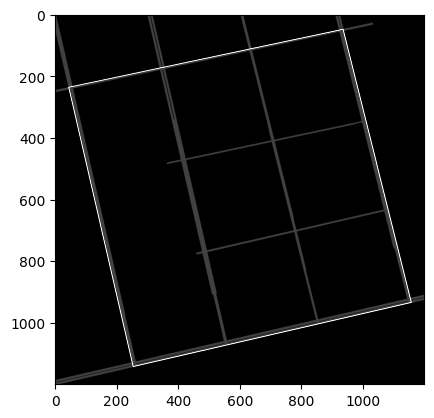

In [31]:
if flag_image_dark or flag_image_hard:
  p1 = sorted(intersections, key = lambda p: p[0] + p[1])[0] # topleft
  p2 = sorted(intersections, key = lambda p: p[0] - p[1])[0] # topright
  p3 = sorted(intersections, key = lambda p: p[0] + p[1])[-1] # bottright
  p4 = sorted(intersections, key = lambda p: p[1] - p[0])[0] # bottleft
  coords = np.int32([[p1[::-1], p2[::-1], p3[::-1], p4[::-1]]])
  tmp_img3 = np.zeros_like(dilated_image, dtype = np.int32)
  tmp_img3 = cv2.polylines(tmp_img3, coords, isClosed=True, color=(2550,0,0))
  plt.imshow(tmp_img3 + tmp_img, cmap="gray", vmax=1000)

In [32]:
if flag_image_noisy:

  kernel = np.ones((3, 3), np.uint8)
  dilated_image = cv2.morphologyEx(dilated_image, cv2.MORPH_ERODE, kernel)
  dilated_image = cv2.morphologyEx(dilated_image, cv2.MORPH_DILATE, np.ones((7, 7), np.uint8))
  plt.imshow(dilated_image, cmap="gray")

In [33]:
def detect_corners_of_largest_square(binary_image , mylist):
    # Apply a blur to reduce noise
    blur = cv2.GaussianBlur(binary_image, (5, 5), 0)

    # Detect edges
    edges = cv2.Canny(blur, 50, 150, apertureSize=3)

    # Find contours
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Check if contours are found
    if contours:
        #Find the largest contour by area
        largest_contour = max(contours, key=cv2.contourArea)

        # Approximate the contour to a polygon
        epsilon = 0.02 * cv2.arcLength(largest_contour, True)
        approx_polygon = cv2.approxPolyDP(largest_contour, epsilon, True)

        # Process only if the approximated polygon has more than 4 points
        if len(approx_polygon) > 4:
            # Sort the points based on x-coordinate and then y-coordinate
            sorted_points = sorted(approx_polygon, key=lambda point: (point[0][0], point[0][1]))
            top_right = max(sorted_points, key=lambda point: point[0][0] - point[0][1])
            top_left = min(sorted_points, key=lambda point: point[0][0] + point[0][1])
            bottom_left = min(sorted_points, key=lambda point: point[0][0] - point[0][1])
            bottom_right = max(sorted_points, key=lambda point: point[0][0] + point[0][1])
            mylist.append(top_left)
            mylist.append(top_right)
            mylist.append(bottom_right)
            mylist.append(bottom_left)
            # Create a new list with the four corners
            corners = np.array([top_left, top_right, bottom_left, bottom_right])
        else:
            sorted_points = sorted(approx_polygon, key=lambda point: (point[0][0], point[0][1]))

            # Assuming the top-left corner will have the smallest sum of x and y,
            # and the bottom-right will have the largest sum.
            top_left = min(sorted_points, key=lambda point: point[0][0] + point[0][1])
            bottom_right = max(sorted_points, key=lambda point: point[0][0] + point[0][1])

            # The top-right corner will have the largest difference between x and y,
            # and the bottom-left will have the smallest difference.
            top_right = max(sorted_points, key=lambda point: point[0][0] - point[0][1])
            bottom_left = min(sorted_points, key=lambda point: point[0][0] - point[0][1])
            mylist.append(top_left)
            mylist.append(top_right)
            mylist.append(bottom_right)
            mylist.append(bottom_left)

            # Create a new list with the four corners
            corners = np.array([top_left, top_right, bottom_right, bottom_left])

        # Draw circles on the corners
        for point in corners:
            cv2.circle(binary_image, tuple(point[0]), 10, (255, 0, 0), -1)


    # Save or display the result
        return binary_image

In [34]:
if (not flag_image_dark) and (not flag_image_hard):
  mylist = []

  binary_image = detect_corners_of_largest_square(dilated_image , mylist)

  for i in mylist:
    print(i)
  plt.imshow(binary_image, cmap="gray")

In [37]:
if (not flag_image_dark) and (not flag_image_hard):
  p1 = mylist[0]
  p2 = mylist[1]
  p3 = mylist[2]
  p4 = mylist[3]
  tmp_img = np.zeros_like(binary_image, dtype = np.uint8)

  coords = np.int32([[p1[::-1], p2[::-1], p3[::-1], p4[::-1]]])
  tmp_img3 = np.zeros_like(binary_image, dtype = np.int32)
  tmp_img3 = cv2.polylines(tmp_img3, coords, isClosed=True, color=(2550,0,0))
  plt.imshow(tmp_img3 + binary_image, cmap="gray", vmax=1000)

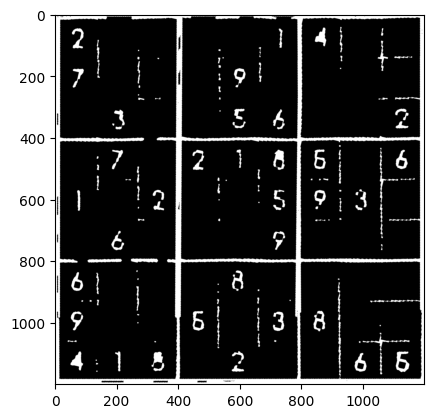

In [38]:
y, x = dilated_image.shape
src_coords = np.float32([[0,0], [x,0], [x,y], [0,y]])
dst_coords = np.float32([p1[::-1], p2[::-1], p3[::-1], p4[::-1]])
img_gray_threshed_warped = cv2.warpPerspective(
    src=dilated_image,
    M=cv2.getPerspectiveTransform(dst_coords, src_coords),
    dsize=dilated_image.shape[::-1]
)
plt.imshow(img_gray_threshed_warped, cmap="gray")

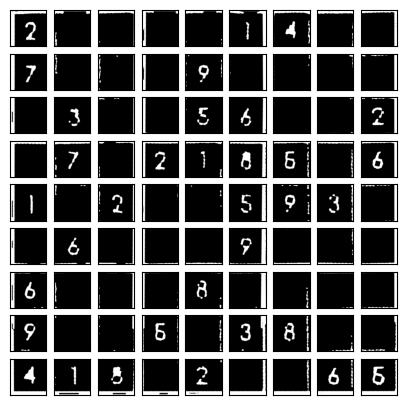

In [39]:
M = img_gray_threshed_warped.shape[0] // 9
N = img_gray_threshed_warped.shape[1] // 9
number_tiles = []
for i in range(9):
    number_tiles.append([])
    for j in range(9):
        tile = img_gray_threshed_warped[i*M:(i+1)*M, j*N:(j+1)*N]
        number_tiles[i].append(tile)

_, axes = plt.subplots(9, 9, figsize=(5, 5))
for i, row in enumerate(axes):
    for j, col in enumerate(row):
        col.imshow(number_tiles[i][j], cmap="gray")
        col.get_xaxis().set_visible(False)
        col.get_yaxis().set_visible(False)

In [40]:


# Save the image using OpenCV
cv2.imwrite(f'phase1_output/{testing__image}.jpg', img_gray_threshed_warped, [cv2.IMWRITE_JPEG_QUALITY, 100])


True

In [41]:
""""import cv2
import os

output_folder = f'phase1_digits/{testing__image}/'
os.makedirs(output_folder, exist_ok=True)

# Save each image from the number_tiles list to the folder
for i, row in enumerate(number_tiles):
    for j, img in enumerate(row):
        # Convert the image to a NumPy array and ensure it's scaled to 0-255 (8-bit unsigned integers)
        img_np = (img * 255).astype(np.uint8) if not isinstance(img, np.ndarray) else img
        
        # Save the image using OpenCV with row and column numbers in the filename
        filename = os.path.join(output_folder, f'tile_{i}_{j}.jpg')  # Change format if needed (e.g., .jpg)
        cv2.imwrite(filename, img_np)""""


SyntaxError: unterminated string literal (detected at line 15) (2637286657.py, line 15)